# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.


**Исходные данные:** Данные о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 
<br>**Наша задача:** определить параметров, вляющих на стоимость квартиры. 
<br>**План работы:** 
1. Изучить общую информацию о данных.
2. Выполнить предобработку (удалить дубликаты, отформатировать даннные, удалить пропуски).
3. Добавить новые параметры.
4. Изучить, как быстро продавались квартиры.
5. Определить факторы, которые больше всего влияют на общую (полную) стоимость объекта.
6. Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
7. Выяснить как меняется среднняя стоимость квартир с удалением от центра Санкт-Петербурга.
8. Сделать вывод.

### Откройте файл с данными и изучите общую информацию

Октроем датасет, импортируем библиотеки и настроим параметры для корректного отображения.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import locale
import numpy as np

pd.set_option("display.max_columns", 40)
pd.options.display.float_format='{:,.2f}'.format
plt.rcParams['figure.figsize']=(10,6)

try:
    #data = pd.read_csv('real_estate_data.csv', sep='\t')
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except: 
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

data.head()

Выведем общую информацию о датафрейме

In [ ]:
data.info()

Построим гисторграмму для всех числовых столбцов

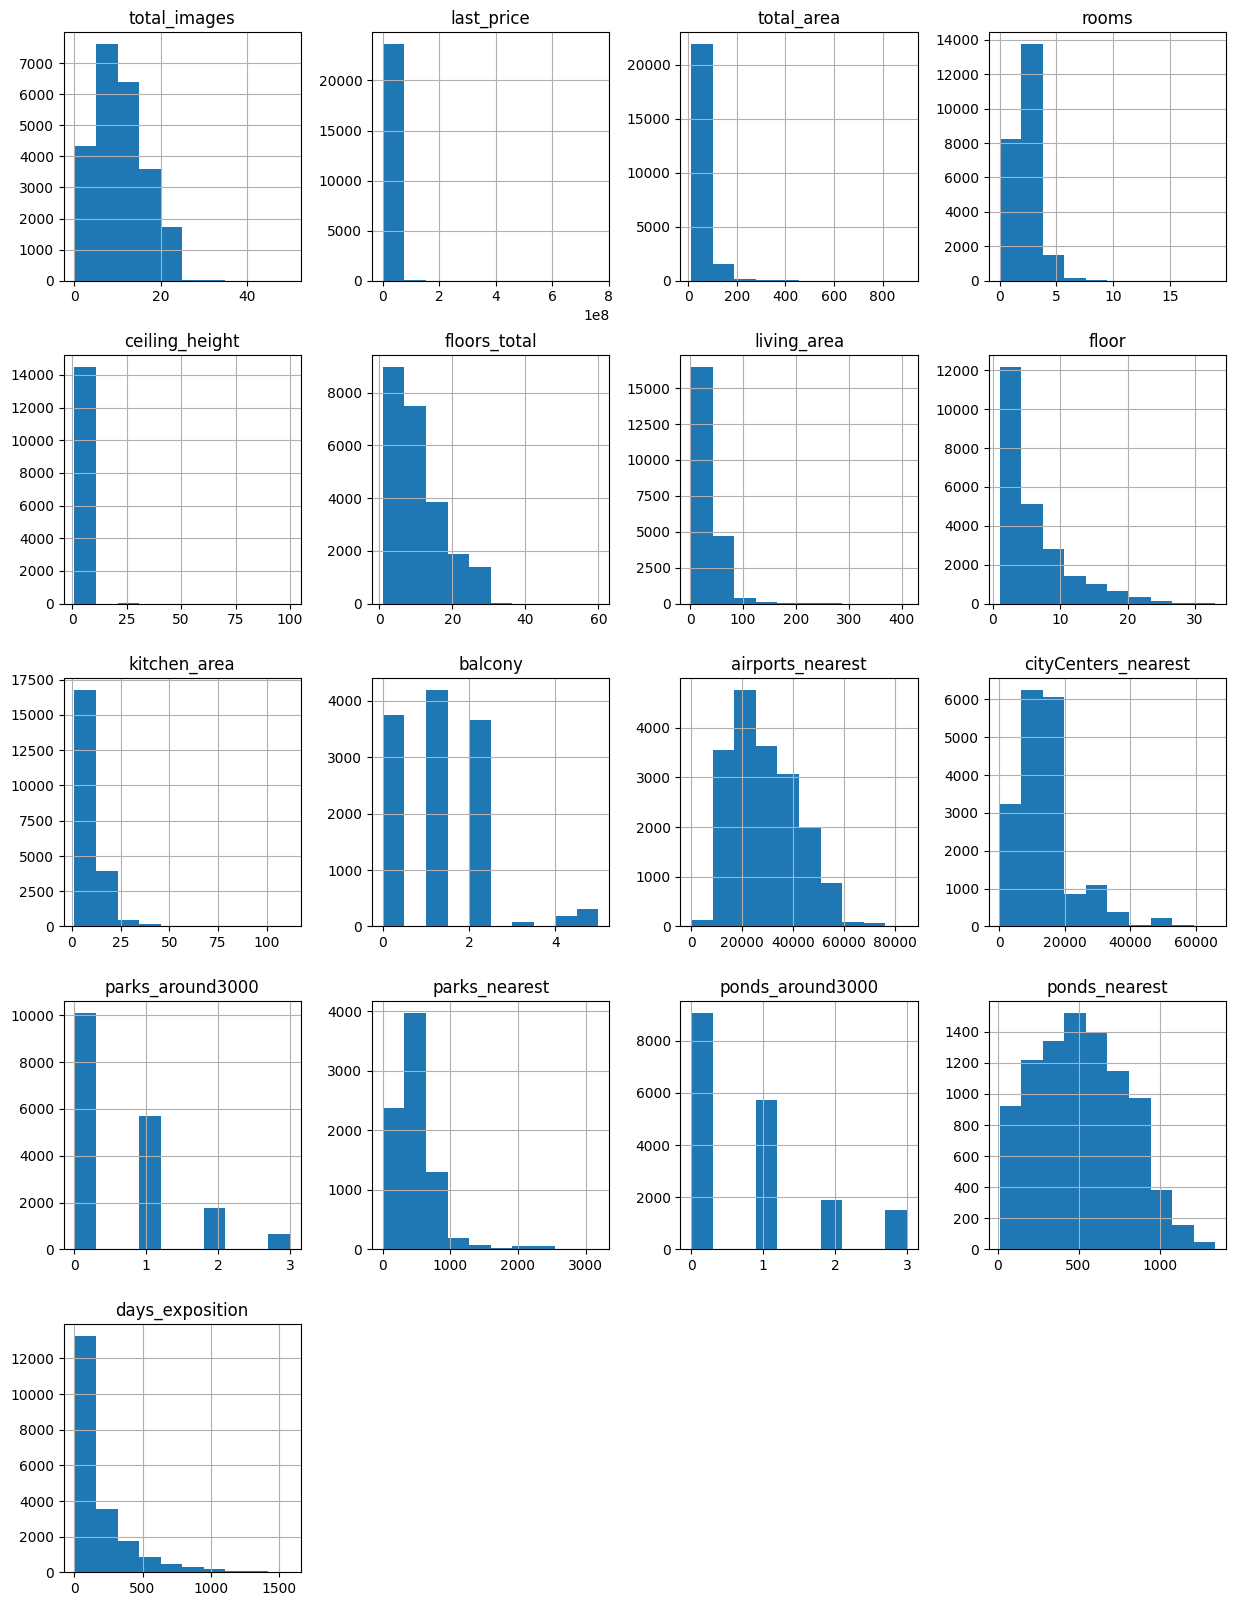

In [3]:
data.hist(figsize=(15,20))
plt.title('Распределение данных')
plt.show()

Промежуточные выводы из гистогрмм распределния:
<br> 1) Чаще всего встречается около 10 фотографий в объявлениях.
<br>2) Цена на момент снятия объявления меньше 100 000 000, основная масса квартир продовалась до 50 000 000 рублей.
<br>3) Общая площадь квартир в основном до 200 квадратных метров.
<br>4) В основном количество комнат от 2 до 3.
<br>5) Есть выбросы данных, отвечающих за высоту потолков в районе 25 метров.
<br>6) С уменьшением количества данных уменьшается количество этажей в доме.
<br>7) Жилая площадь квартиры в основном до 100 квадратных метров.
<br>8) В основном продаваемые квартиры находились на невыскоих этажах.
<br>9) Площадь кухни в основном до 25 квадратных метров.
<br>10) Число балконов, как правило, до двух.
<br>11) Расстояние до ближайшего аэропорта от 10 000 до 50 000 метров.
<br>12) Расстояние до центра города в основном до 20 000 метров.
<br>13) Больше всего квартир, в радиусе 3км от которых, нет парков.
<br>14) Расстояние до ближайших парков до 1 км. (есть несоотвествие с предыдущим пунктом, которое может вызывано  пропусками данныx в этом пункте)
<br>15) Больше всего квартир, в радиусе 3км от которых, нет прудов.
<br>16) Почти все квартиры находятся в расстояние от 1 км от прудов.( Также несоотвествие с предыдущим пунктом из-за пропусков данных)
<br>17) В основном объявления висели в выдаче до 500 дней.




### Выполните предобработку данных

Найдем и удалим явные дубликаты, если они есть.

In [4]:
data.duplicated().sum()

0

Определяем количество пропущенных значений для каждого столбца

In [25]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area               143
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area              205
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Рассмотрим подробнее данными, в которых есть пропуски.

In [26]:
print(np.sort(data['ceiling_height'].unique()))
print('Медиана', data['ceiling_height'].median())
print('Доля пропусков', data['ceiling_height'].isna().sum() / len(data['ceiling_height']))

[ 1.    1.2   1.75  2.    2.2   2.25  2.26  2.3   2.34  2.4   2.45  2.46
  2.47  2.48  2.49  2.5   2.51  2.52  2.53  2.54  2.55  2.56  2.57  2.58
  2.59  2.6   2.61  2.62  2.63  2.64  2.65  2.66  2.67  2.68  2.69  2.7
  2.71  2.72  2.73  2.74  2.75  2.76  2.77  2.78  2.79  2.8   2.81  2.82
  2.83  2.84  2.85  2.86  2.87  2.88  2.89  2.9   2.91  2.92  2.93  2.94
  2.95  2.96  2.97  2.98  2.99  3.    3.01  3.02  3.03  3.04  3.05  3.06
  3.07  3.08  3.09  3.1   3.11  3.12  3.13  3.14  3.15  3.16  3.17  3.18
  3.2   3.21  3.22  3.23  3.24  3.25  3.26  3.27  3.28  3.29  3.3   3.31
  3.32  3.33  3.34  3.35  3.36  3.37  3.38  3.39  3.4   3.42  3.43  3.44
  3.45  3.46  3.47  3.48  3.49  3.5   3.51  3.52  3.53  3.54  3.55  3.56
  3.57  3.58  3.59  3.6   3.62  3.63  3.65  3.66  3.67  3.68  3.69  3.7
  3.75  3.76  3.78  3.8   3.82  3.83  3.84  3.85  3.86  3.87  3.88  3.9
  3.93  3.95  3.98  4.    4.06  4.1   4.14  4.15  4.19  4.2   4.25  4.3
  4.37  4.4   4.45  4.5   4.65  4.7   4.8   4.9   5.   

В столбце высота потолков пропуски занимают почти 40%. Такие пропуски могли возникнуть в результате незаполнения пользователем данного значения, например в связи с незнанием высоты квартиры. Так как это довольно большее количество, заменим их медианнм значением. Также можно заметить аномальные значения в виде 24 метров и т.д, такие данные могли возникнуть из-за отпечаток, когда имелось в виду 2.4 метра. Заменим такие данные. 

In [27]:
data.loc[data['ceiling_height'] > 14, 'ceiling_height'] = (data['ceiling_height'] / 10 )

In [28]:
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median().round(2)
data['ceiling_height'].isna().sum()

0

In [29]:
np.sort(data['floors_total'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

In [30]:
data['floors_total'].isna().sum()/len(data['floors_total'])

0.0036288450989493226

Значение пропусков в столбце "всего этажей в доме" составлеят примерно 0.3%, что не является существенным числом. Данные пропуки могли возникнуть из-за технической ошибки в данныx, либо из-за человеческого фактора. (Пользователь забыл, не увидел). Поэтому такие пропуски можно оставить.

Пропуски в столбце жилая площадь могли возникнуть из-за человеческого фаткора (незнание жилой площади). При этом пропусков в столбце общая площадь нет. Можем обработать такие пропуски средним значением в зависимости от общей площади квартиры.

In [31]:
for t in data['total_area'].unique():
    data.loc[(data['total_area'] == t) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area'] == t), 'living_area'].mean()

Пропуски в данных балкона могли возникнуть в результате того, что в квартире нет балкона. Заменим данные значения на 0 Аналогично пропуски в данных апартаментов могли возникнуть в результате того, что квартира не является апартаментами. Заменим также на 0.

In [32]:
data.loc[data['balcony'].isna(), 'balcony'] = 0

Заметим, что формат данных 'is_apartment' - строки, когда по условию должен быть булевый тип. Изменим формат.

In [33]:
data['is_apartment'] = data['is_apartment'].astype(bool)

In [34]:
data.loc[data['is_apartment'].isna()] = False

Пропуски в столбце площадь кухни могли возникнуть из-за человеческого фаткора (незнание жилой площади). При этом пропусков в столбце общая площадь нет. Можем обработать такие пропуски средним значением в зависимости от общей площади квартиры.

In [35]:
for t in data['total_area'].unique():
    data.loc[(data['total_area'] == t) & (data['kitchen_area'].isna()), 'kitchen_area'] = data.loc[(data['total_area'] == t), 'kitchen_area'].mean()

Рассмотрим также данные с пропусками в столбце название населённого пункта. Доля таких пропуков небольшая, поэтому оставим такие данные.

In [36]:
data['locality_name'].isna().sum()/ len(data['locality_name'])

0.002067597788936242

Пропуски также есть и  в картографических данных, которые заполнены были автоматичсеки. Пропуски могли возникнуть из-за технической ошибки. Такие данные пока оставим.

Таким образом, были обнаружены пропуски в 14 столбцах. Были заменены значения высоты потолков в квартире, которые возникли из-за опечаток. Также заменены пропущенные значения в жилой площади квартиры и площади кухни на средние значения от общей площади квартиры. А также найдены пропуски в автоматически заполняемых картографических данных, их мы оставили. 

In [37]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23556 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23494 non-null  float64       
 13  balcony         

Рассмотрим типы данных и изменим его там, где это необходимо.

In [38]:
data.loc[:,'studio'] = data['floors_total'].astype(bool)

In [39]:
data.loc[:,'balcony'] = data['balcony'].astype('int')

In [40]:
data.loc[:,'open_plan'] = data['open_plan'].astype(bool)

In [41]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Тип данных был изменен на булевый в столбцах студия, свободная планировка и апартмаенты, т.к значения, которые там встречаются True/False. Также тип данных был изменен на int в столбце  и кол-во балконов. Также тип данных должен быть целым в столбцах всего этажей в доме, количество парков и прудов в радиусе 3 км, но там пока есть пропуски, поэтому тип данных: число с плавающей точкой. Изменен тип на datetime в данных с датами.

Расммотрим все значения в названиях населенных пунктов и удалим неявные дубликаты.

In [42]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [43]:
data['locality_name'].nunique()

363

In [44]:
data.loc[:,'locality_name'] = data['locality_name'].replace('поселок городского типа Рябово', 'поселок Рябово')

In [45]:
data.loc[:,'locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [46]:
data.loc[:,'locality_name'] = data['locality_name'].replace(['село Павлово','поселок городского типа Павлово','городской поселок Павлово'], 'поселок Павлово')

In [47]:
data.loc[:,'locality_name'] = data['locality_name'].replace('поселок станции Громово' , 'поселок Громово')

In [48]:
data.loc[:,'locality_name'] = data['locality_name'].replace(['городской поселок', 'поселок городского типа', 'деревня', 'село'], 'поселок')

In [49]:
data['locality_name'].nunique()

327

In [50]:
data.reset_index(drop=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,True,True,False,11.00,2.00,поселок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,"9,700,000.00",133.81,2017-03-21,3,3.70,5.00,73.30,3,True,True,False,13.83,0.00,Санкт-Петербург,"24,665.00","4,232.00",1.00,796.00,3.00,381.00,NaN
23695,14,"3,100,000.00",59.00,2018-01-15,3,2.65,5.00,38.00,4,True,True,False,8.50,0.00,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.00
23696,18,"2,500,000.00",56.70,2018-02-11,2,2.65,3.00,29.70,1,True,True,False,8.82,0.00,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,"11,475,000.00",76.75,2017-03-28,2,3.00,17.00,NaN,12,True,True,False,23.30,2.00,Санкт-Петербург,"39,140.00","10,364.00",2.00,173.00,3.00,196.00,602.00


### Добавьте в таблицу новые столбцы

Рассчитаем цену за 1 квадратный метр и добавим в таблицу.

In [51]:
data['square_meter_price'] = (data['last_price'] / data['total_area'])
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,"120,370.37"
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,True,True,False,11.00,2.00,поселок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,"82,920.79"
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,"92,785.71"
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,"408,176.10"
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,"100,000.00"


Отформатируем дату публикации и добавим столбцы с днем недели, месяцем и годом публикации.

In [52]:
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

In [53]:
data['weekday_exposition'] = data['first_day_exposition'].dt.strftime('%A')

In [54]:
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year

Добавим тип этажа квартиры в зависимости от значения этажа.

In [55]:
def floor_name(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else: return 'другой'

In [56]:
data['floor_name'] = data.apply(floor_name, axis=1)

Добавим столбец с расстоянием до центра города в километрах.

In [57]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000)

In [58]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,"120,370.37",3,Thursday,2019,другой,16.03
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,True,True,False,11.00,2.00,поселок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,"82,920.79",12,Tuesday,2018,первый,18.60
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,"92,785.71",8,Thursday,2015,другой,13.93
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,"408,176.10",7,Friday,2015,другой,6.80
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,"100,000.00",6,Tuesday,2018,другой,8.10


### Проведите исследовательский анализ данных

Изучим данные по отдельности.

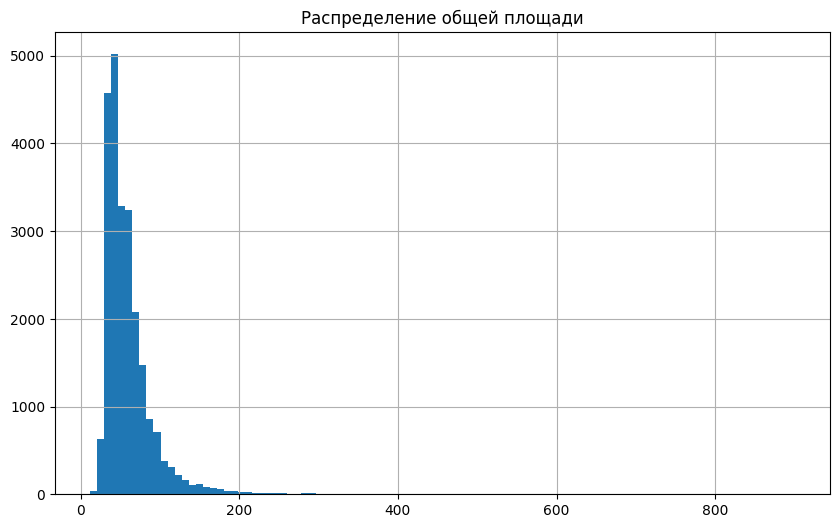

In [59]:
data['total_area'].hist(bins=100)
plt.title('Распределение общей площади')
plt.show()

In [60]:
data[data['total_area'] > 400]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km
660,3,"49,950,000.00",483.90,2017-10-04,7,3.20,6.00,312.50,4,True,True,False,26.40,0.00,Санкт-Петербург,"23,079.00",945.00,3.00,461.00,3.00,22.00,391.00,"103,223.81",10,Wednesday,2017,другой,0.94
3117,19,"140,000,000.00",631.00,2019-03-30,7,2.65,5.00,NaN,5,True,True,False,60.00,0.00,Санкт-Петербург,"25,707.00","4,972.00",0.00,NaN,2.00,210.00,NaN,"221,870.05",3,Saturday,2019,последний,4.97
3676,12,"28,789,000.00",441.98,2019-01-23,4,2.65,6.00,NaN,6,True,True,False,35.05,0.00,Санкт-Петербург,"20,552.00","5,181.00",0.00,NaN,0.00,NaN,NaN,"65,136.43",1,Wednesday,2019,последний,5.18
4237,1,"50,000,000.00",517.00,2017-10-14,7,2.65,4.00,332.00,3,True,True,False,22.00,0.00,Санкт-Петербург,"22,835.00","1,847.00",2.00,477.00,2.00,540.00,NaN,"96,711.80",10,Saturday,2017,другой,1.85
5358,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6.00,409.00,3,True,True,False,100.00,0.00,Санкт-Петербург,"24,447.00","4,666.00",1.00,767.00,0.00,NaN,14.00,"110,169.49",2,Thursday,2019,другой,4.67
5893,3,"230,000,000.00",500.00,2017-05-31,6,2.65,7.00,NaN,7,True,True,False,40.00,0.00,Санкт-Петербург,"32,440.00","5,297.00",0.00,NaN,2.00,198.00,50.00,"460,000.00",5,Wednesday,2017,последний,5.30
6221,8,"34,000,000.00",470.30,2018-01-14,4,2.65,3.00,248.70,3,True,True,False,40.00,0.00,Санкт-Петербург,"43,756.00","15,459.00",1.00,852.00,3.00,122.00,179.00,"72,294.28",1,Sunday,2018,последний,15.46
6621,20,"99,000,000.00",488.00,2017-04-09,5,2.95,20.00,216.00,17,True,True,False,50.00,0.00,Санкт-Петербург,"27,641.00","4,598.00",1.00,646.00,1.00,368.00,351.00,"202,868.85",4,Sunday,2017,другой,4.60
8018,20,"84,000,000.00",507.00,2015-12-17,5,4.45,7.00,301.50,7,True,True,False,45.50,1.00,Санкт-Петербург,NaN,"5,735.00",2.00,110.00,0.00,NaN,"1,078.00","165,680.47",12,Thursday,2015,последний,5.74
9826,1,"43,185,328.00",494.10,2017-05-12,1,2.85,12.00,NaN,3,True,True,False,NaN,0.00,Санкт-Петербург,"28,529.00","6,832.00",1.00,592.00,0.00,NaN,5.00,"87,402.00",5,Friday,2017,другой,6.83


In [61]:
data['total_area'].describe()

count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

In [62]:
data = data.query('total_area < 400')

Основная масса квартир имеют площадь до 100 квадратрных метров, при этом есть и 26 квартир с площадью больше 400. Такие данные являются редкими, поэтому удалим их.
В среднем общая площадь квартир находится в диапазолне от 40 до 70 квадртаных метров, об этом говорит 25 и 75 процентиль.

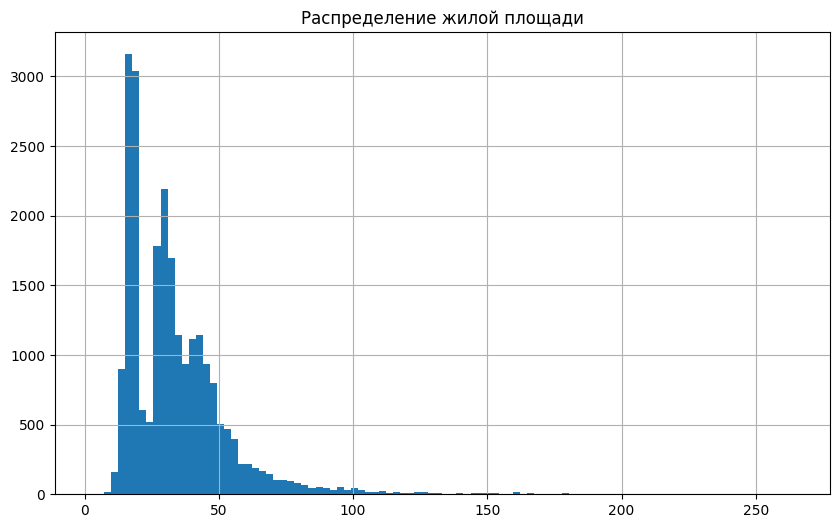

In [63]:
data['living_area'].hist(bins=100)
plt.title('Распределение жилой площади')
plt.show()

In [64]:
data['living_area'].describe()

count   23,536.00
mean        34.24
std         20.58
min          2.00
25%         18.70
50%         30.00
75%         42.20
max        264.50
Name: living_area, dtype: float64

In [65]:
len(data[data['living_area'] > 100])

356

Аналогично общей площади жилая площадь в основном расположена в промежутке до 50 квадртаных метров. Также есть редкие значения большие 100 квадртаных метров. Удалим их. Есть пики данных в районе 25 квадртаных метров.

In [66]:
data = data.query('living_area < 100')

In [67]:
data['living_area'].value_counts()

living_area
18.00    882
17.00    676
30.00    598
16.00    486
20.00    481
        ... 
36.81      1
46.13      1
29.43      1
30.86      1
42.55      1
Name: count, Length: 1993, dtype: int64

In [68]:
data.query('living_area == 18')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km
49,1,"3,050,000.00",30.80,2018-11-22,1,2.50,9.00,18.00,7,True,True,False,6.00,0.00,Санкт-Петербург,"45,341.00","16,603.00",1.00,675.00,0.00,NaN,NaN,"99,025.97",11,Thursday,2018,другой,16.60
78,9,"4,350,000.00",37.00,2018-02-22,1,2.65,19.00,18.00,6,True,True,False,10.70,0.00,Санкт-Петербург,"34,324.00","14,192.00",0.00,NaN,0.00,NaN,45.00,"117,567.57",2,Thursday,2018,другой,14.19
100,16,"3,800,000.00",38.60,2018-02-22,1,2.65,9.00,18.00,6,True,True,False,8.40,2.00,Санкт-Петербург,"36,450.00","13,364.00",0.00,NaN,0.00,NaN,8.00,"98,445.60",2,Thursday,2018,другой,13.36
102,7,"3,700,000.00",33.00,2016-04-15,1,2.65,14.00,18.00,2,True,True,False,6.20,1.00,Санкт-Петербург,"49,214.00","16,140.00",0.00,NaN,0.00,NaN,88.00,"112,121.21",4,Friday,2016,другой,16.14
111,4,"4,590,000.00",40.00,2017-05-29,1,2.65,6.00,18.00,1,True,True,False,10.00,0.00,Санкт-Петербург,"20,062.00","6,175.00",1.00,241.00,0.00,NaN,31.00,"114,750.00",5,Monday,2017,первый,6.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23635,9,"5,100,000.00",36.00,2018-10-26,1,2.80,15.00,18.00,11,True,True,False,8.00,0.00,Санкт-Петербург,"13,643.00","11,673.00",0.00,NaN,1.00,405.00,60.00,"141,666.67",10,Friday,2018,другой,11.67
23651,7,"3,350,000.00",41.00,2018-12-17,1,2.65,6.00,18.00,1,True,True,False,12.00,0.00,поселок городского типа Токсово,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"81,707.32",12,Monday,2018,первый,NaN
23656,13,"2,600,000.00",32.00,2017-07-12,1,2.65,5.00,18.00,2,True,True,False,7.00,0.00,Колпино,"26,074.00","31,861.00",2.00,231.00,2.00,371.00,195.00,"81,250.00",7,Wednesday,2017,другой,31.86
23677,8,"2,450,000.00",35.00,2018-10-26,1,2.60,5.00,18.00,4,True,True,False,9.60,0.00,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,28.00,"70,000.00",10,Friday,2018,другой,NaN


Рассмотрев общее количество данных по группам, можно сделать вывод, что больше всего данных с площадью 18 квадратных метров. В остальном жилая площадь квартир обычно находится в диапазоне 18 - 45 квадртаных метров.

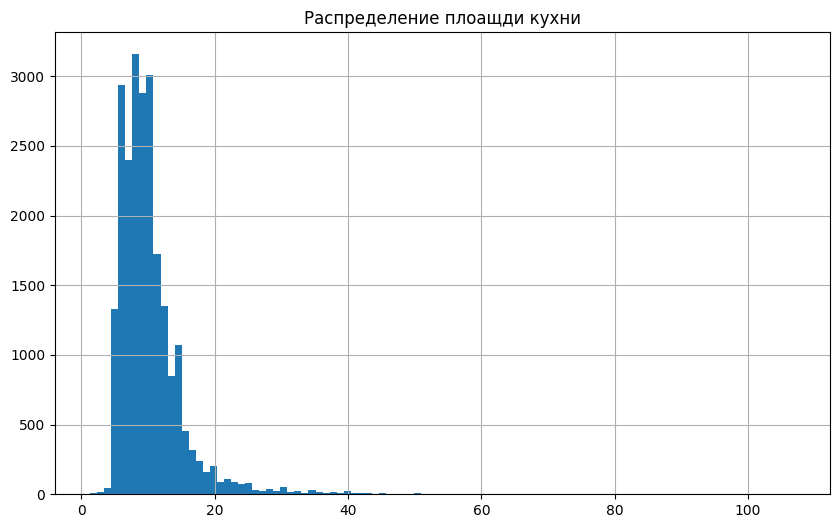

In [69]:
data['kitchen_area'].hist(bins=100)
plt.title('Распределение плоащди кухни')
plt.show()

In [70]:
data['kitchen_area'].describe()

count   23,023.00
mean        10.27
std          5.26
min          1.30
25%          7.00
50%          9.00
75%         11.52
max        107.00
Name: kitchen_area, dtype: float64

In [71]:
len(data[data['kitchen_area'] > 50])

31

Данные с площадью кухни распределены аналогично данным с общей площадью квартиры, что выглдяит логичным.

In [72]:
data = data.query('kitchen_area < 50')

Площадь кухни находится в диапазоне 7 - 12 квадратных метров. Мы удалили редкие даныне с площадью, большей 50 квадртных метров.

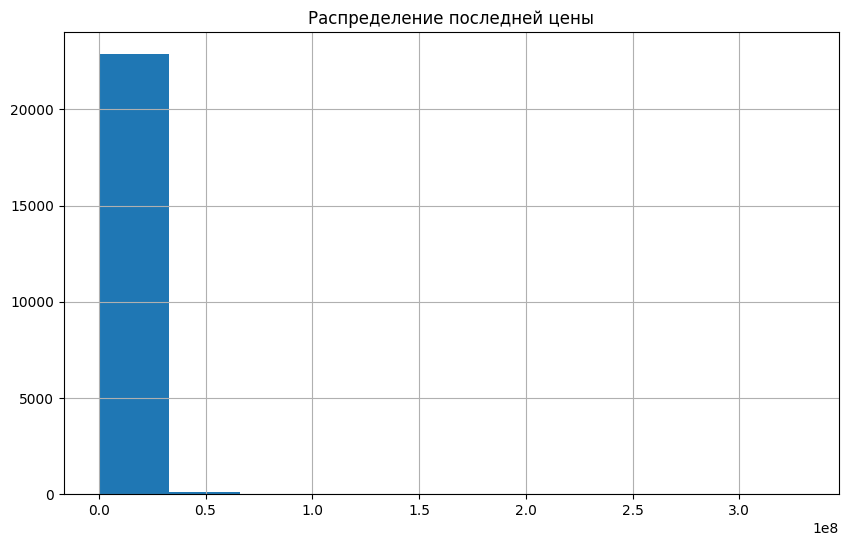

In [73]:
data['last_price'].hist(bins=10)
plt.title('Распределение последней цены')
plt.show()

Так как значения цены объекта слишком большие, они скновертированы в формат 1e8. Рассмотрим цены в миллионах рублей.

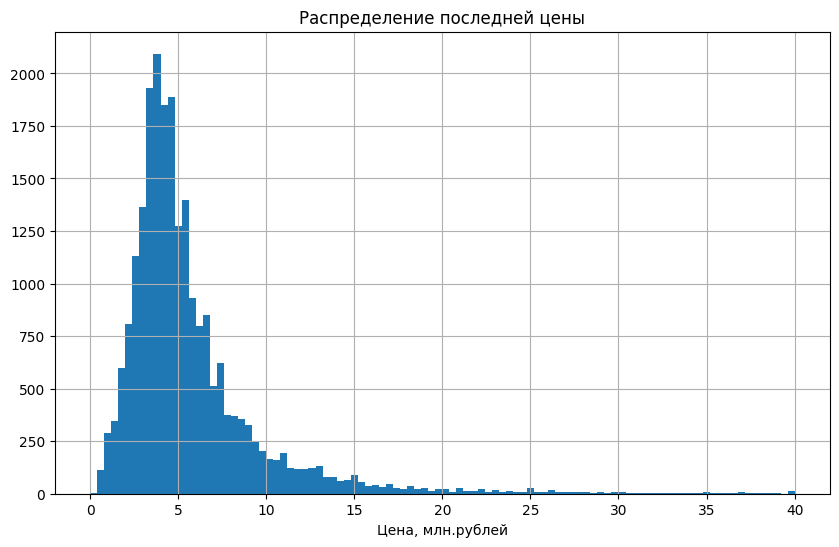

In [74]:
(data['last_price']/1000000).hist(bins=100, range=(0,40))
plt.title('Распределение последней цены')
plt.xlabel('Цена, млн.рублей')
plt.show()

In [75]:
data['last_price'].describe()

count        22,985.00
mean      5,843,702.85
std       5,661,022.98
min          12,190.00
25%       3,400,000.00
50%       4,600,000.00
75%       6,600,000.00
max     330,000,000.00
Name: last_price, dtype: float64

Средняя стоимость прродажи квартир составляет около 6 000 000 рублей. 

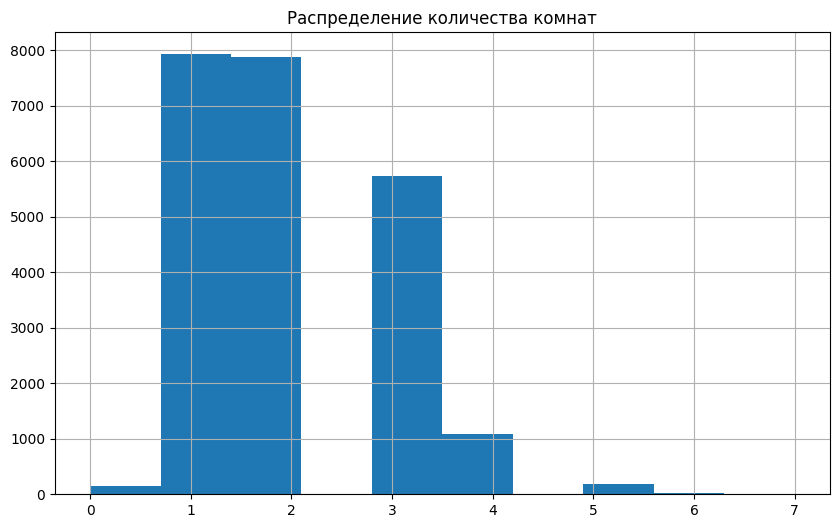

In [76]:
data['rooms'].hist()
plt.title('Распределение количества комнат')
plt.show()

In [77]:
data['rooms'].describe()

count   22,985.00
mean         2.02
std          0.95
min          0.00
25%          1.00
50%          2.00
75%          3.00
max          7.00
Name: rooms, dtype: float64

Максимальное количество комнат в квартирах = 7, в основном продаются однокомнатые, двухкомнатные и трехкомнатные квартиры.

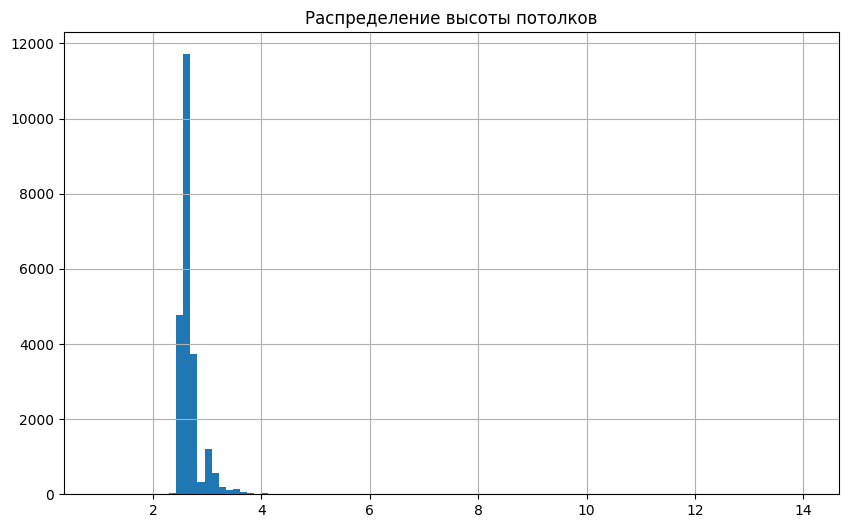

In [78]:
data['ceiling_height'].hist(bins=100)
plt.title('Распределение высоты потолков')
plt.show()

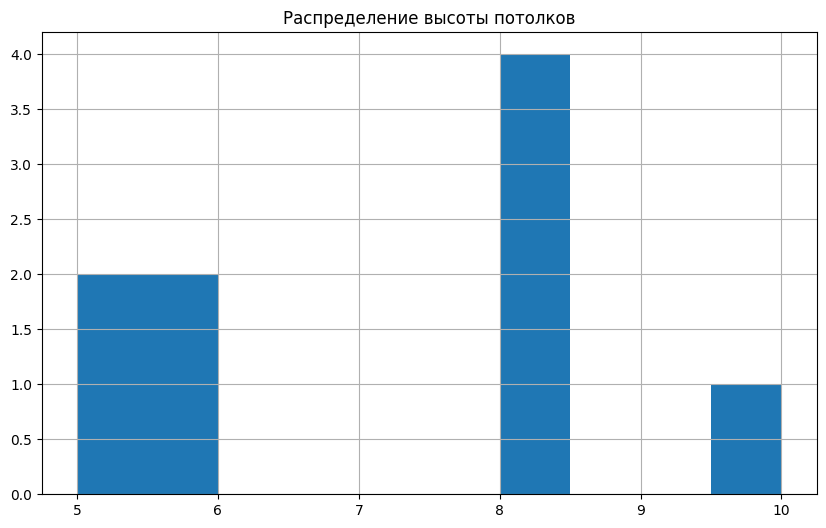

In [79]:
data['ceiling_height'].hist(bins=10, range=(5,10))
plt.title('Распределение высоты потолков')
plt.show()

Можно заметить выбросы данных, большие, чем 8 метров. Удалим их.

In [80]:
data = data.query('ceiling_height < 8')

In [81]:
data['ceiling_height'].describe()

count   22,978.00
mean         2.69
std          0.20
min          1.00
25%          2.60
50%          2.65
75%          2.70
max          5.80
Name: ceiling_height, dtype: float64

После удаления аномальных значений высоты потолков, в среднем высота сотавляет 2.7 метра.

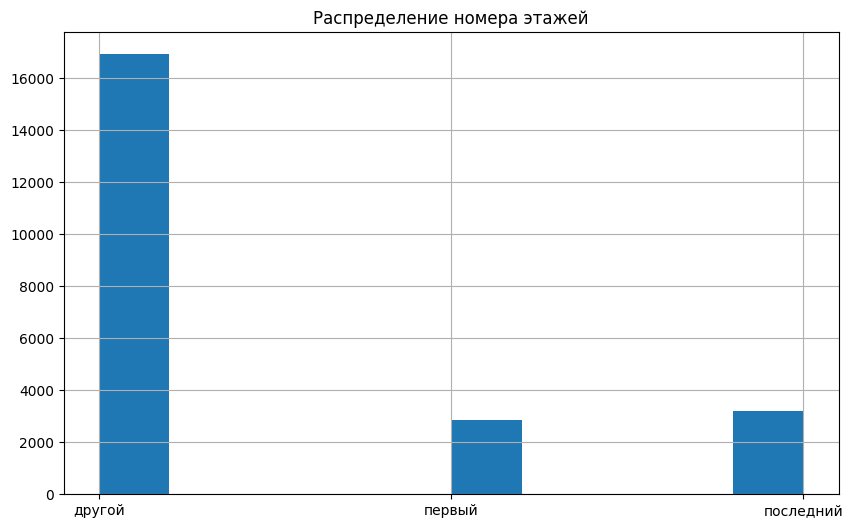

In [82]:
data['floor_name'].hist()
plt.title('Распределение номера этажей')
plt.show()

Квартир на первом и последнем этаже значительно меньше, чем на остальных.

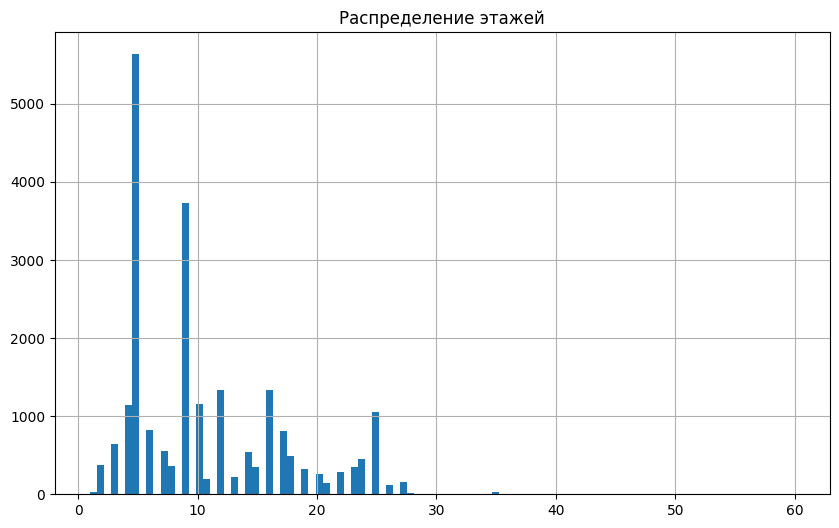

In [83]:
data['floors_total'].hist(bins=100)
plt.title('Распределение этажей')
plt.show()

In [84]:
data['floors_total'].describe()

count   22,913.00
mean        10.69
std          6.59
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

По графику видно, что есть редкие квартиры, находящиеся выше 30 этажа.

In [85]:
data = data.query('floors_total < 30')

In [86]:
len(data)

22882

Мы удалили редкие данные с квартирыми выше 30 этажа, основная масса квартир находится с 5 по 16 этаж.

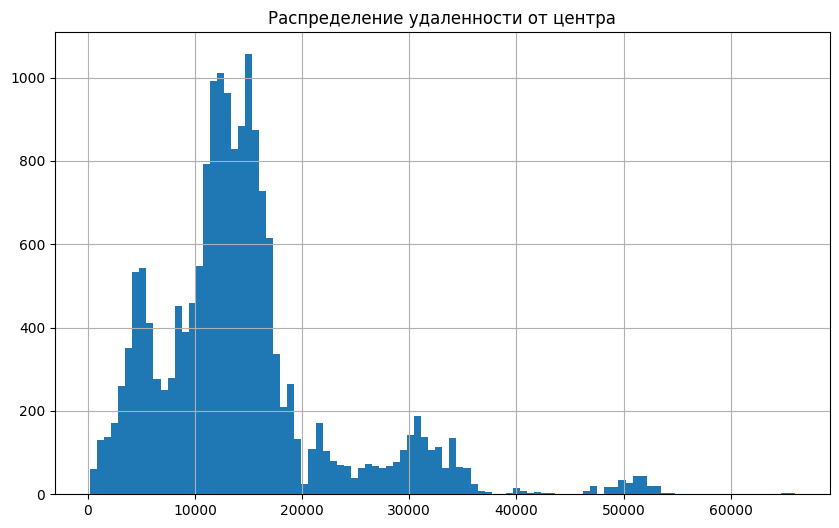

In [87]:
data['cityCenters_nearest'].hist(bins=100)
plt.title('Распределение удаленности от центра')
plt.show()

In [88]:
data['cityCenters_nearest'].describe()

count   17,487.00
mean    14,373.02
std      8,589.10
min        208.00
25%      9,585.00
50%     13,219.00
75%     16,340.50
max     65,968.00
Name: cityCenters_nearest, dtype: float64

В осноновм все квартиры находятся не дальше 16 000 км от центра. 

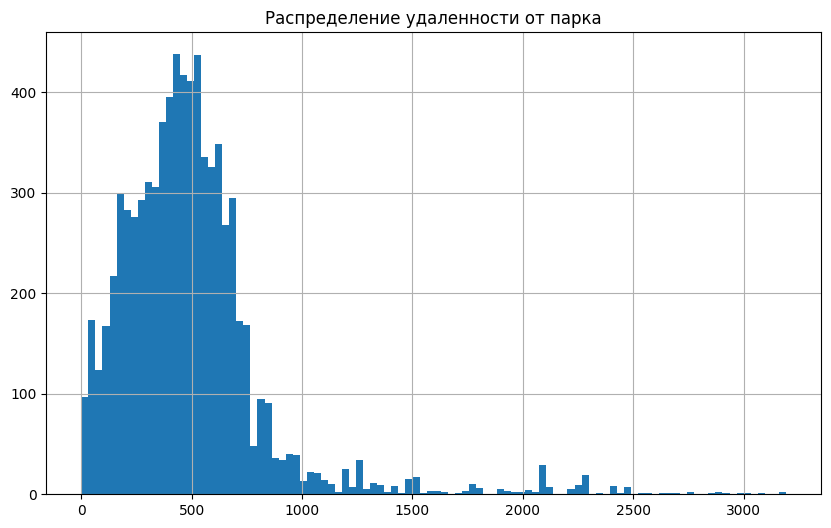

In [89]:
data['parks_nearest'].hist(bins=100)
plt.title('Распределение удаленности от парка')
plt.show()

In [90]:
data['parks_nearest'].describe()

count   7,679.00
mean      492.41
std       342.49
min         1.00
25%       288.00
50%       456.00
75%       613.00
max     3,190.00
Name: parks_nearest, dtype: float64

Данные по удаленности от парков представлены всего в 7679 квартирах, среди которых основная масса удалена не дальше 500 метров.

Изучим как быстро продавались квартиры.

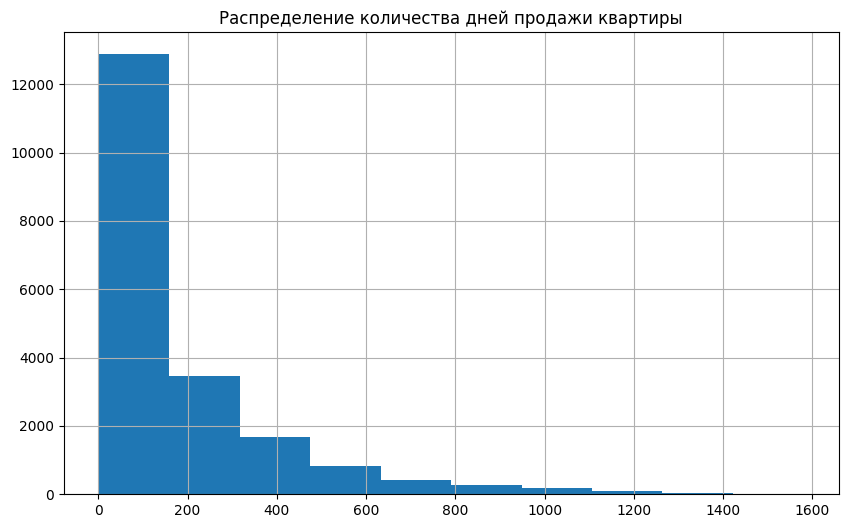

In [91]:
data['days_exposition'].hist()
plt.title('Распределение количества дней продажи квартиры')
plt.show()

Описание данных
count   19,841.00
mean       179.14
std        217.64
min          1.00
25%         45.00
50%         95.00
75%        229.00
max      1,580.00
Name: days_exposition, dtype: float64


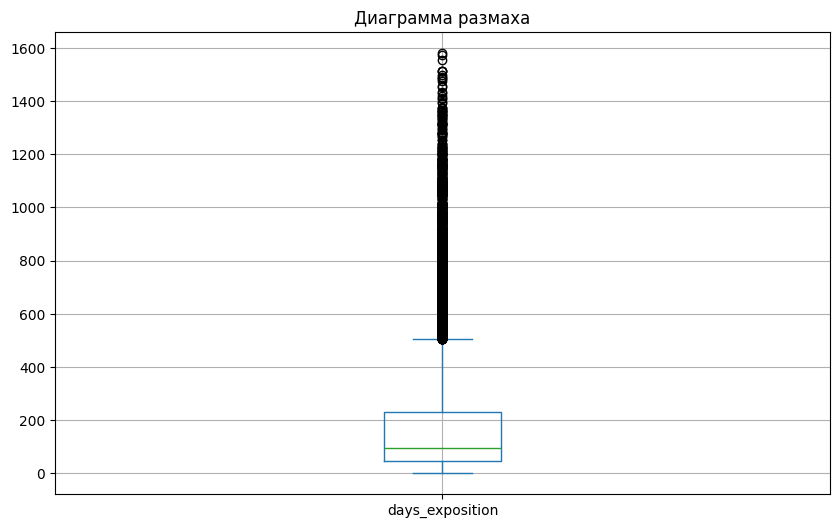

In [92]:
try: 
    print('Описание данных')
    print(data['days_exposition'].describe())
    data['days_exposition'].plot(kind='box', title='Диаграмма размаха', grid=True)
    plt.show()
except:  
    print('Описание данных')
    print(data['days_exposition'].describe())

In [93]:
len(data[data['days_exposition']>600]) / len(data['days_exposition'])

0.04938379512280395

Выбросы сотсавляют менее 5%, но при этом если мы удалим их, то потеряем больше 10% от первоначальных данных, сотсавим новую таблицу с удаленными выбросами непосредственно для анализа срока продаж квартир.

In [94]:
data1 = data.query('days_exposition < 600')

Описание данных
count   18,707.00
mean       138.42
std        136.40
min          1.00
25%         42.00
50%         88.00
75%        193.50
max        599.00
Name: days_exposition, dtype: float64


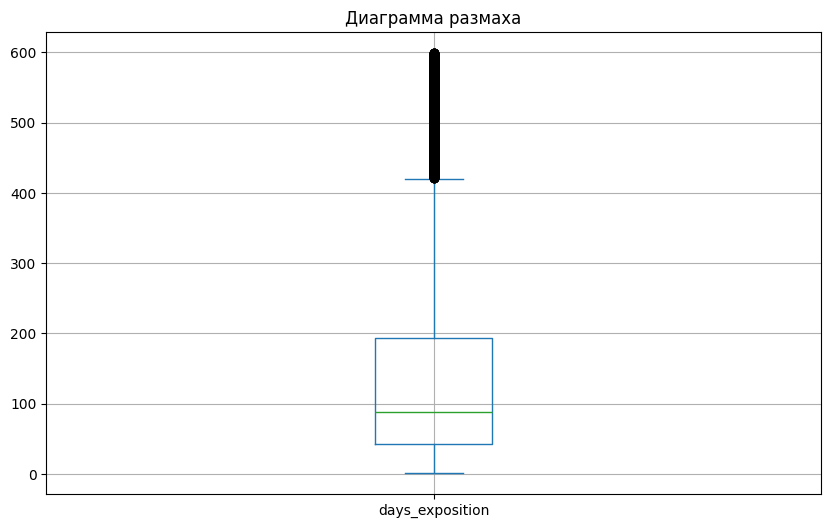

In [95]:
try: 
    print('Описание данных')
    print(data1['days_exposition'].describe())
    data1['days_exposition'].plot(kind='box', title='Диаграмма размаха', grid=True)
    plt.show()
except:  
    print('Описание данных')
    print(data1['days_exposition'].describe())

Таким образом, в среднем продажа квартир занимает около 140 дней. Быстрыми продажами будем считать значения, меньшие нижнего квартиля, то есть быстрее 40 дней. Долгими продажами - значения, которые больше верхнего квартиля, то есть больше 194 дней.

Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

Определим зависимость цены от площади.

In [96]:
def grafic(par1, name, numeric):
    #d1 = data.groupby(par1)['last_price'].mean().reset_index()
    d1 = data.groupby(par1)['last_price'].apply(lambda x:sum(x/len(x))).reset_index()
    if numeric == True:
        print('Корреляция', d1.corr(), sep='\n')
    else: print('')
    plt.title(f'Зависимость между параметром "{name}"  и стоимостью квартиры.')
    plt.xlabel(name, color='gray')
    plt.ylabel('Стоимость квартиры', color='gray')
    plt.plot(d1[par1], d1['last_price'])
    return plt.show()

Корреляция
            total_area  last_price
total_area        1.00        0.74
last_price        0.74        1.00


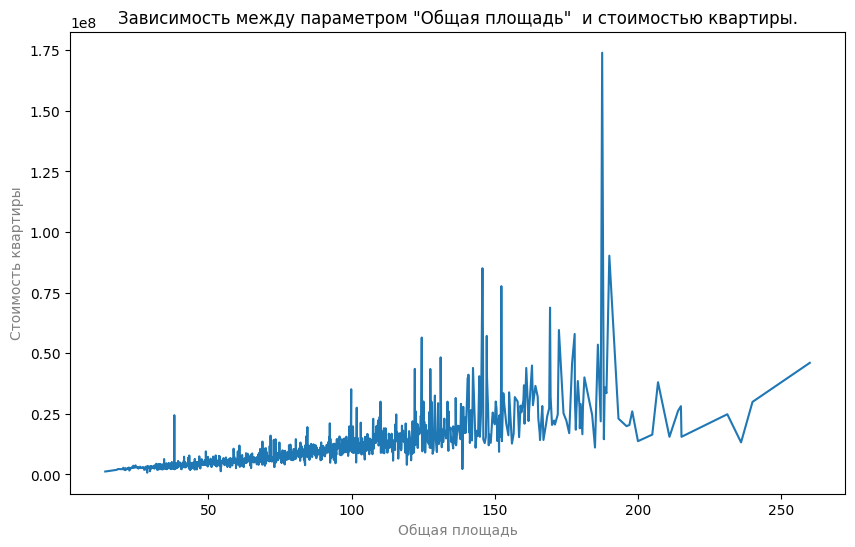

In [97]:
grafic('total_area', 'Общая площадь', True)

In [98]:
len(data.query('total_area > 200')) / len(data)

0.0005681321562800455

Можно заметить, что с ростом площади растет и стоимость квратир. Есть исключения - квартиры, с площадью большей, чем 275 квадртаных метров. Но доля таких квартир меньше 1%, что не является существенной выборкой.

In [99]:
data = data.query('living_area > 5')

Корреляция
             living_area  last_price
living_area         1.00        0.68
last_price          0.68        1.00


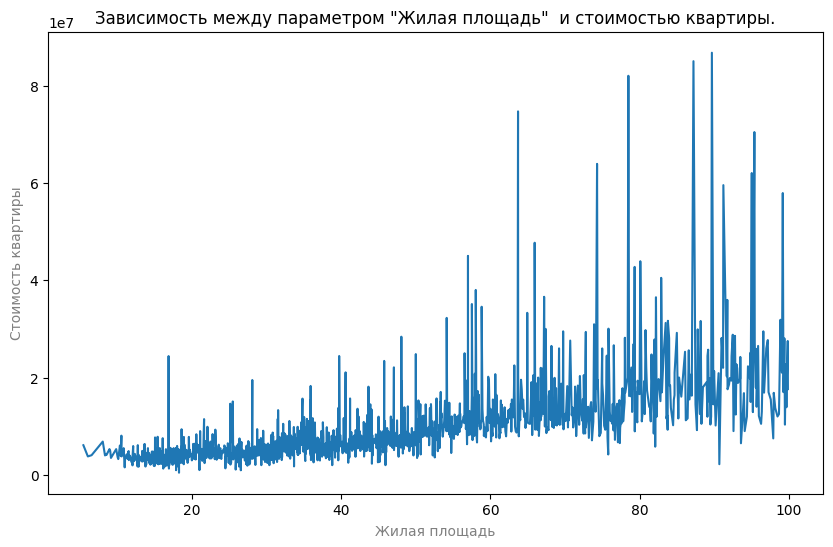

In [100]:
grafic('living_area', 'Жилая площадь', True)

Стоимость квартиры растет с увеличением жилой площади квартиры.

Корреляция
              kitchen_area  last_price
kitchen_area          1.00        0.58
last_price            0.58        1.00


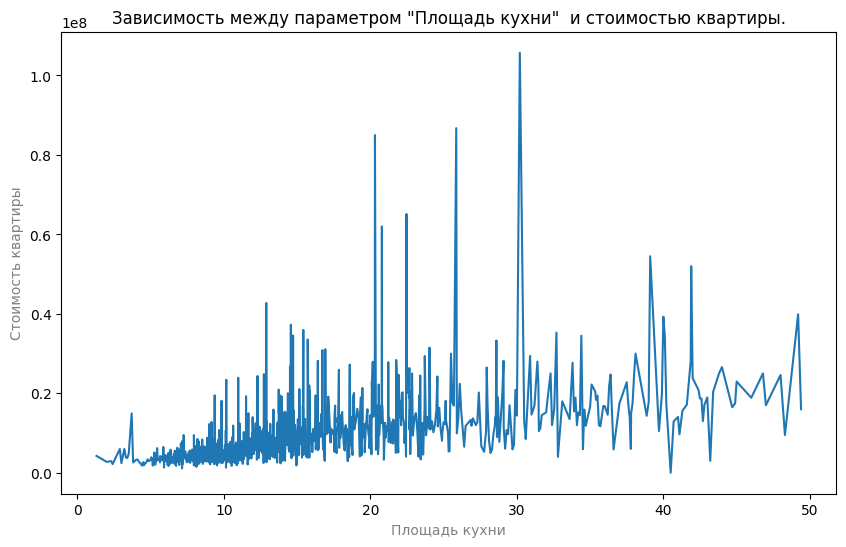

In [101]:
grafic('kitchen_area', 'Площадь кухни', True)

По графику видно, что площадь кухни не существенно влияет на стоимость квартиры, так как значения площади кухни сильно меняются с изменением цены. Коэффициент корреляции равен 0.58

Корреляция
            rooms  last_price
rooms        1.00        0.99
last_price   0.99        1.00


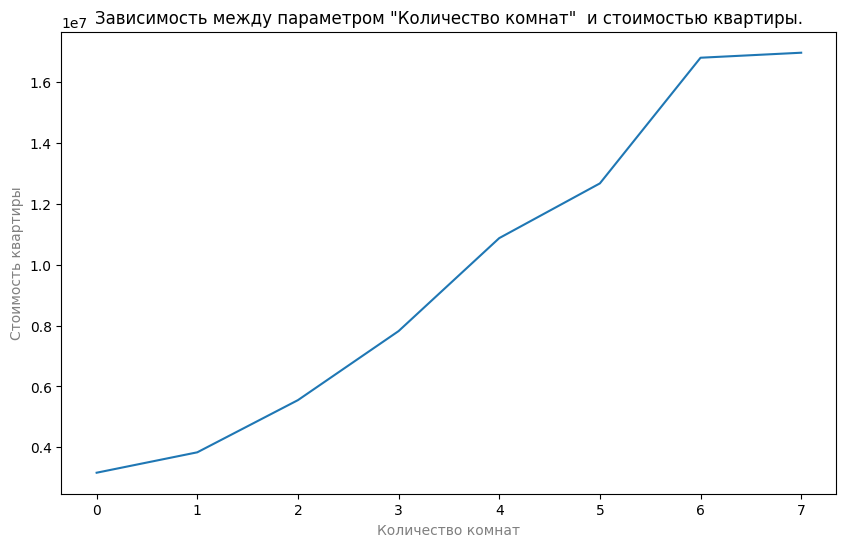

In [102]:
grafic('rooms', 'Количество комнат', True)

С увеличением комнат существенно растет стоимость квартир. Коэффициент корреляции равен 0.99, что гвоорит о сильной зависимости между данным параметром и стоимостью квартиры.

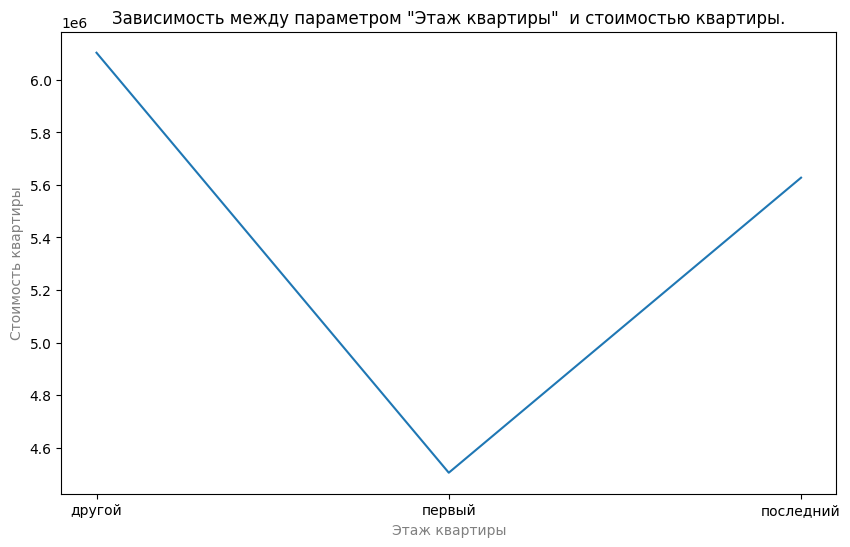

In [103]:
grafic('floor_name', 'Этаж квартиры', False)

Самые дешевые квартиры находятся на первом этаже.

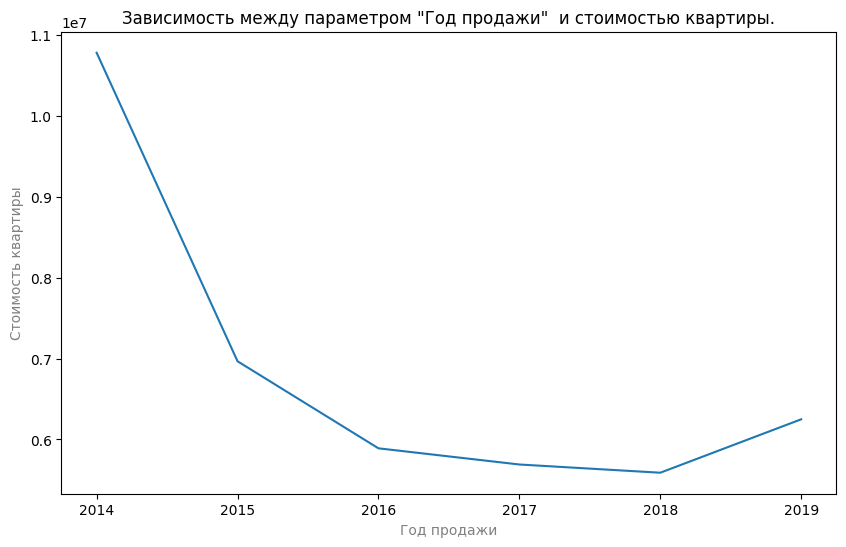

In [104]:
grafic('year_exposition', 'Год продажи', False)

Начиная с 2014 и до 2018 года стоимость квартир падала, в 2019 году произошел небольшой рост.

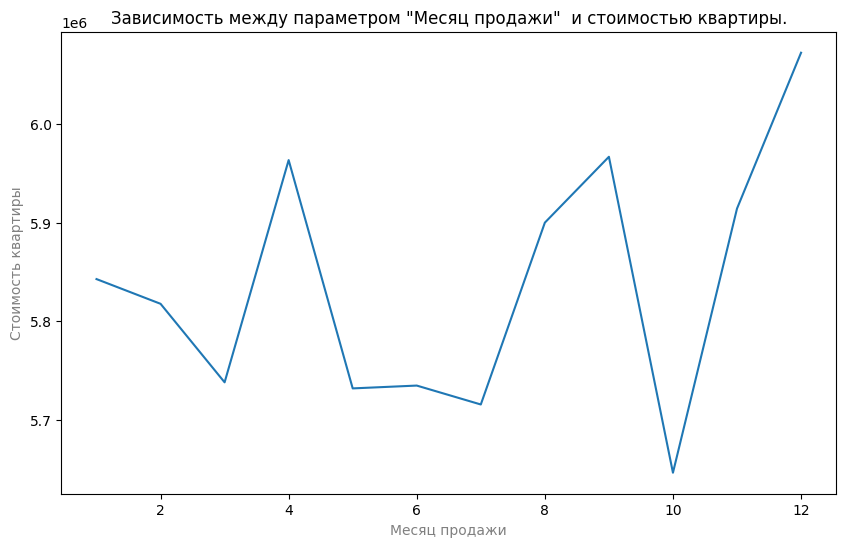

In [105]:
grafic('month_exposition', 'Месяц продажи', False)

Самые дорогие продажи с объявлением, размещенным в декабре, а самыми недорогими - в октябре.

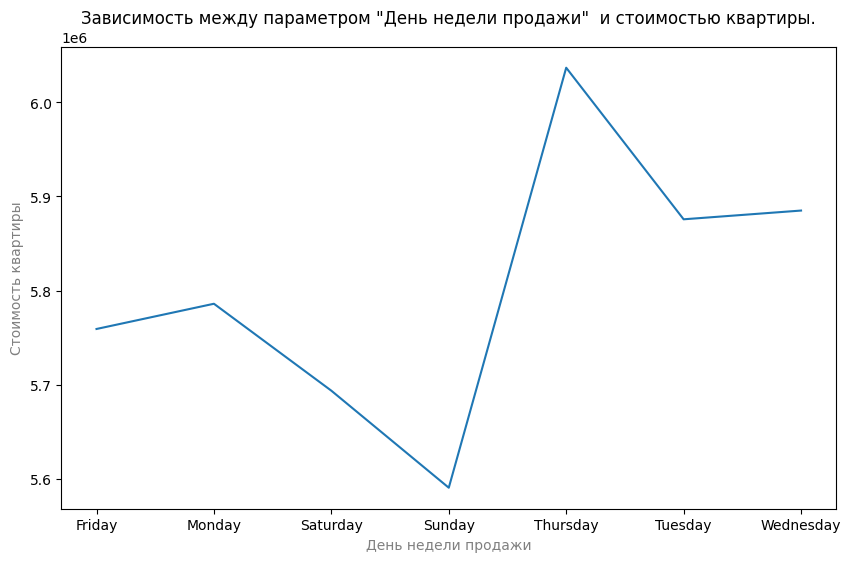

In [106]:
grafic('weekday_exposition', 'День недели продажи', False)

Самые дорогие продажи с объявлением, размещенным в четверг, а самыми недорогими - в воскресенье.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [107]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,"120,370.37",3,Thursday,2019,другой,16.03
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,True,True,False,11.00,2.00,поселок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,"82,920.79",12,Tuesday,2018,первый,18.60
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,"92,785.71",8,Thursday,2015,другой,13.93
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,"408,176.10",7,Friday,2015,другой,6.80
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,"100,000.00",6,Tuesday,2018,другой,8.10


In [108]:
#data_sorted = data.pivot_table(index='locality_name', values='square_meter_price',aggfunc=['mean','count'])

In [109]:
data_sorted = data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['sum', 'count'])

In [110]:
data_sorted.columns=['sum','count']

In [111]:
data_sorted['mean'] = data_sorted['sum'] / data_sorted['count']

In [112]:
data_sorted.sort_values('count', ascending=False).head(10).sort_values('mean', ascending=False)

,sum,count,mean
locality_name,,,
Санкт-Петербург,"1,695,673,129.96",15045,"112,706.76"
Пушкин,"36,699,254.48",358,"102,511.88"
деревня Кудрово,"26,424,683.28",286,"92,394.00"
поселок Парголово,"29,448,317.75",326,"90,332.26"
поселок Мурино,"43,289,387.23",508,"85,215.33"
поселок Шушары,"34,484,040.26",439,"78,551.34"
Колпино,"25,306,427.05",336,"75,316.75"
Гатчина,"21,052,096.83",306,"68,797.70"
Всеволожск,"27,199,438.68",396,"68,685.45"


Таким образом среди 10 населенных пунктов с наибольшим числом объявлений самый дорогой квадртаный метр в Санкт-Петербурге, а самый дешевый в Выборге.

In [113]:
data_spb = data.query('locality_name == "Санкт-Петербург"')

In [114]:
data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,"120,370.37",3,Thursday,2019,другой,16.03
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,"92,785.71",8,Thursday,2015,другой,13.93
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,"408,176.10",7,Friday,2015,другой,6.80
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,"100,000.00",6,Tuesday,2018,другой,8.10
7,5,"7,915,000.00",71.60,2019-04-18,2,2.65,24.00,42.77,22,True,True,False,18.90,2.00,Санкт-Петербург,"23,982.00","11,634.00",0.00,NaN,0.00,NaN,NaN,"110,544.69",4,Thursday,2019,другой,11.63


Добавим столбец с целой частью количества км до центра.

In [115]:
def distance(num):
    return int(num)

Нас интересуте данные без пропусков, поэтому удалим их в столбце с расстояние до центра в км.

In [116]:
data_spb = data_spb.query('~cityCenters_nearest_km.isna()')

In [117]:
data_spb.loc[:,'cityCenters_nearest_grouped_km'] = data_spb['cityCenters_nearest_km'].apply(distance)

In [118]:
data_spb.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,month_exposition,weekday_exposition,year_exposition,floor_name,cityCenters_nearest_km,cityCenters_nearest_grouped_km
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,True,True,False,25.00,0.00,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,"120,370.37",3,Thursday,2019,другой,16.03,16
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,True,True,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,"92,785.71",8,Thursday,2015,другой,13.93,13
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,80.20,9,True,True,False,16.10,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,"408,176.10",7,Friday,2015,другой,6.80,6
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,True,True,False,41.00,0.00,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,"100,000.00",6,Tuesday,2018,другой,8.10,8
7,5,"7,915,000.00",71.60,2019-04-18,2,2.65,24.00,42.77,22,True,True,False,18.90,2.00,Санкт-Петербург,"23,982.00","11,634.00",0.00,NaN,0.00,NaN,NaN,"110,544.69",4,Thursday,2019,другой,11.63,11


In [119]:
#data_spb_pivot = data_spb.pivot_table(index='cityCenters_nearest_grouped_km', values='last_price').sort_values('cityCenters_nearest_grouped_km')

In [120]:
data_spb_pivot = data_spb.pivot_table(index='cityCenters_nearest_grouped_km', values='last_price', aggfunc=['sum', 'count'])

In [121]:
data_spb_pivot.columns = ['sum', 'count']

In [122]:
data_spb_pivot['mean'] = data_spb_pivot['sum'] / data_spb_pivot['count']

In [123]:
data_spb_pivot = data_spb_pivot.drop(['sum','count'], axis=1)

In [124]:
data_spb_pivot

,mean
cityCenters_nearest_grouped_km,
0,"14,996,313.45"
1,"14,729,016.91"
2,"11,885,710.19"
3,"9,746,420.50"
4,"10,983,584.54"
5,"11,063,783.66"
6,"11,859,875.11"
7,"10,119,026.51"
8,"8,098,431.96"


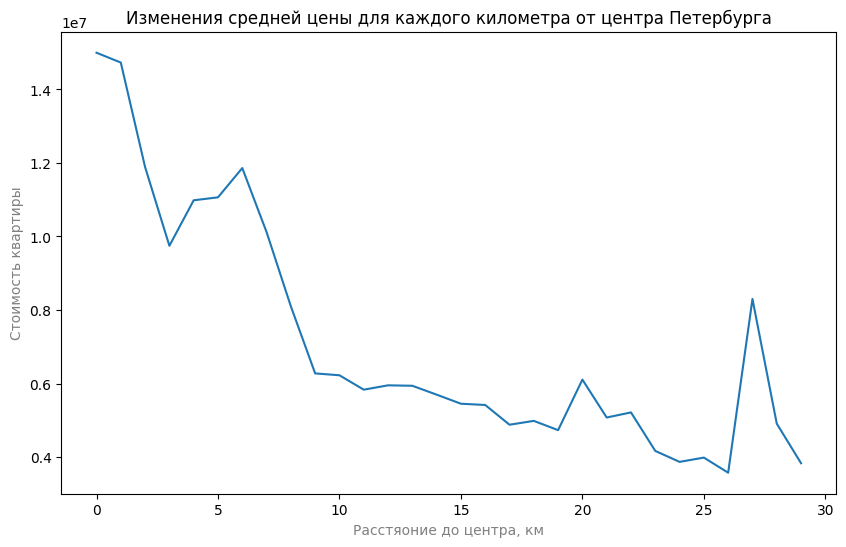

In [125]:
plt.title('Изменения средней цены для каждого километра от центра Петербурга')
plt.xlabel('Расстяоние до центра, км', color='gray')
plt.ylabel('Стоимость квартиры', color='gray')
plt.plot(data_spb_pivot)
plt.show()

На графике видно, что с удаленностью от центра Санкт-Петербугра уменьшается и стоимость квартиры.

### Общий вывод

Исходные данные -  данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. На первом этапе мы выявили и заполнили пропуски. Удалили дубликаты в данных. А также добавили новые параметры для исследования:(цена одного квадратного метра; день публикации объявления, месяц публикации объявления, год публикации объявления, тип этажа квартиры,расстояние до центра города в километрах).
На втором этапе оценили какие параметры вляют на стоимость квартиры и пришли к следующим выводам:
<br> 1) Чем больше общая и жилая площадь, тем больше стоимость квартир.
<br> 2) Стоимость квартир растет с увеличением комнат.
<br> 3) На первом и последнем этаже квартиры значительно дешевле, чем на остальных.
<br> 4) С увеличением высоты потолков незначительно растет стоимость квартир, при этом самые дорогие квартиры с высотой 3.85 метра.
<br> 5) Начиная с 2014 и до 2018 года стоимость квартир падала, в 2019 году произошел небольшой рост.
<br> 6) Самые дорогие продажи с объявлением, размещенным в июне, а самыми недорогими - в октябре.
<br> 7) Cреди 10 населенных пунктов с наибольшим числом объявлений самый дорогой квадртаный метр в Санкт-Петербурге, а самый дешевый в Выборге.
<br> 8) C удаленностью от центра Санкт-Петербугра уменьшается и стоимость квартиры.